# <font color='#badc58'> Fake News Detector with LSTM |<br> </font>  
# <font color='#3dc1d3'>  
1.  Preprocess data
2.  one_hot encoding
3.  create LSTM model
4.  observe the alteration in shape, flattening and then re-shaping - changes from embedding to flattening - to - dense layer <br>
5. Observe the total weight matrix size of the LSTM - mathematical verification

## <font color='#f9ca24'> LSTM
 <font color='00BFEB'>'fit' or train on some training data; joins these two steps and is used for the initial fitting of parameters on the training set 𝑥, while also returning the transformed 𝑥′. Internally, the transformer object just calls first fit() and then transform() on the same data.<br>In the output, you will see (20000, 5) which means that each of the document has 5 columns where each column corresponds to the probability value of a particular topic.

In [ ]:
import re
import pandas as pd
import nltk
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# from google.colab import files
# upload = files.upload()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/fakenews.csv")
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### <font color='#badc58'>Let's take a look at the dataset.</font>  <br/>
---


In [ ]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [ ]:
df['label'][0]

1

In [ ]:
df.shape

(20800, 5)

In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

<font color='#badc58'>drop missing data</font>  <br/>

In [ ]:
df = df.dropna(subset=['title','text'])
df.isnull().sum()

id           0
title        0
author    1918
text         0
label        0
dtype: int64

<font color='#badc58'>Preparing to create the model


In [ ]:
x = df.drop(columns='label')
y = df['label']

In [ ]:
print(x['title'][20194])
print(y[20194])

Coincidence? Massive Solar Event Scheduled for Election Night… And Potential Impending Disaster
1


In [ ]:
x.shape, y.shape#array dimensions

((20203, 4), (20203,))

<font color='#7ed6df'>Data Preprocessing

In [ ]:
#create shallow copy - create a new object
copy = x.copy()
#copies the reference of nested objects
copy.reset_index(inplace=True)

In [ ]:
ws = WordNetLemmatizer()
list_titles = []

for i in range(0, len(copy)):
    headline = re.sub('[^a-zA-Z]', ' ', copy['title'][i])
    headline = headline.lower()
    headline = headline.split()
    headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
    headline = ' '.join(headline)
    list_titles.append(headline)

In [ ]:
print(df['title'][5])
print(df['label'][5])

Jackie Mason: Hollywood Would Love Trump if He Bombed North Korea over Lack of Trans Bathrooms (Exclusive Video) - Breitbart
0


In [ ]:
list_titles[2]

'truth might get fired'

In [ ]:
#for i in range(0, len(messages)):
    #print('\n', messages['title'][i])

<font color='#f9ca24'>Keras<font color='#7ed6df'> provide the function <font color='#f9ca24'>one_hot</font> to efficiently encode each word in the titles as an interger.<br>This must be done prior to Word Embedding<br><font color='#7ed6df'>Index of words located in the Dictionary

In [ ]:
vocab = 10000
hot_title = [one_hot(i, vocab) for i in list_titles]
hot_title[:4]

[[6090, 5568, 1713, 1262, 9835, 5416, 6220, 1901, 2831, 3471],
 [112, 2841, 7927, 7828, 5364, 4968, 1767],
 [8974, 3494, 8860, 8789],
 [1068, 3498, 1698, 2160, 1253, 8081]]

<font color='#7ed6df'>Longest sentence<br>

In [ ]:
longest = len(max(list_titles, key = len))
longest

356

<font color='#7ed6df'>Making every sentence of the data of Same Length<br> <font color='#f9ca24'>pad_sequences </font>is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence

In [ ]:
max_length = 356
embed_input = pad_sequences(hot_title, maxlen = max_length, padding='pre')
print(embed_input)

[[   0    0    0 ... 1901 2831 3471]
 [   0    0    0 ... 5364 4968 1767]
 [   0    0    0 ... 3494 8860 8789]
 ...
 [   0    0    0 ... 7958 8383 6043]
 [   0    0    0 ... 3325 2560 8117]
 [   0    0    0 ... 1608  711 9964]]


<font color='#7ed6df'>Arguments: <br>
<font color='#f9ca24'>sequences </font>
List of lists where each element is a sequence<br>
<font color='#f9ca24'>maxlen </font>
int, maximum length of all sequences

<font color='#f9ca24'>dtype </font>	<font color='#7ed6df'>
type of the output sequences

<font color='#f9ca24'>padding </font><font color='#7ed6df'>
'pre' or 'post', pad either before or after each sequence.



<font color='#7ed6df'>Input shape<br>2D tensor with shape: (batch_size, input_length).

<font color='#f9ca24'>Creating the Model

In [ ]:
model = Sequential() #creating the sequential model incrementally vi the add() method
model.add(Embedding(input_dim=vocab, output_dim= 40, input_length=356))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero
#config the model with losses and metrics - compile()
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 356, 40)           400000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              229200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
Total params: 629,501
Trainable params: 629,501
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model1 = Sequential() #creating the sequential model incrementally vi the add() method
model1.add(Embedding(input_dim=vocab, output_dim= 40, input_length=356))
model1.add(LSTM(150))
model1.add(Dense(1, activation='sigmoid'))#sigmoid returns a value close to zero
#config the model with losses and metrics - compile()
model1.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 356, 40)           400000    
                                                                 
 lstm_1 (LSTM)               (None, 150)               114600    
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 514,751
Trainable params: 514,751
Non-trainable params: 0
_________________________________________________________________
None


<font color='#7ed6df'>sequence()a plain stack of layers where each layer has exactly one input tensor and one output tensor<br>create a Sequential model incrementally via the add() method<br>the input of the LSTM is always a 3D array
(batch_size, time_steps, units)<br>
The output of the LSTM could be a 2D array or 3D array depending upon the return_sequences argument.
If return_sequence is False, the output is a 2D array. (batch_size, units)
If return_sequence is True, the output is a 3D array. (batch_size, time_steps, units)<br> in this case; the return_sequence is false - this is the default, therefore - 2D LSTM output

3D tensor with shape: (batch_size, input_length, output_dim).
alteration in shape, flattening and then re-shaping


<font color='#f9ca24'>Describe model

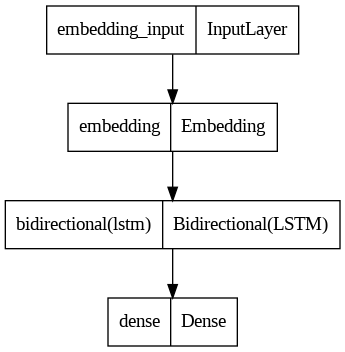

In [ ]:
plot_model(model)

In [ ]:
len(embed_input),y.shape

(20203, (20203,))

In [ ]:
x_final = np.array(embed_input)
y_final = np.array(y)
x_final.shape, y_final.shape

((20203, 356), (20203,))

In [ ]:
x_final

array([[   0,    0,    0, ..., 1901, 2831, 3471],
       [   0,    0,    0, ..., 5364, 4968, 1767],
       [   0,    0,    0, ..., 3494, 8860, 8789],
       ...,
       [   0,    0,    0, ..., 7958, 8383, 6043],
       [   0,    0,    0, ..., 3325, 2560, 8117],
       [   0,    0,    0, ..., 1608,  711, 9964]], dtype=int32)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_final, y_final, test_size=0.4, random_state=42)

In [ ]:
y_train.shape

(12121,)

<font color='#7ed6df'>fitting the model

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
190/190 [==============================] - 36s 139ms/step - loss: 0.3767 - accuracy: 0.8328 - val_loss: 0.2007 - val_accuracy: 0.9250
Epoch 2/10
190/190 [==============================] - 11s 60ms/step - loss: 0.1226 - accuracy: 0.9542 - val_loss: 0.1866 - val_accuracy: 0.9284
Epoch 3/10
190/190 [==============================] - 10s 54ms/step - loss: 0.1073 - accuracy: 0.9620 - val_loss: 0.1964 - val_accuracy: 0.9235
Epoch 4/10
190/190 [==============================] - 11s 59ms/step - loss: 0.0537 - accuracy: 0.9820 - val_loss: 0.2361 - val_accuracy: 0.9284
Epoch 5/10
190/190 [==============================] - 9s 48ms/step - loss: 0.0272 - accuracy: 0.9918 - val_loss: 0.2606 - val_accuracy: 0.9248
Epoch 6/10
190/190 [==============================] - 9s 49ms/step - loss: 0.0372 - accuracy: 0.9890 - val_loss: 0.2402 - val_accuracy: 0.9169
Epoch 7/10
190/190 [==============================] - 9s 50ms/step - loss: 0.0163 - accuracy: 0.9956 - val_loss: 0.3155 - val_accuracy: 0

In [ ]:
history1 = model1.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
190/190 [==============================] - 19s 86ms/step - loss: 0.3207 - accuracy: 0.8518 - val_loss: 0.1853 - val_accuracy: 0.9223
Epoch 2/10
190/190 [==============================] - 7s 37ms/step - loss: 0.1319 - accuracy: 0.9531 - val_loss: 0.2065 - val_accuracy: 0.9196
Epoch 3/10
190/190 [==============================] - 6s 29ms/step - loss: 0.0819 - accuracy: 0.9725 - val_loss: 0.2161 - val_accuracy: 0.9234
Epoch 4/10
190/190 [==============================] - 6s 33ms/step - loss: 0.0419 - accuracy: 0.9858 - val_loss: 0.2673 - val_accuracy: 0.9201
Epoch 5/10
190/190 [==============================] - 6s 31ms/step - loss: 0.0200 - accuracy: 0.9939 - val_loss: 0.3326 - val_accuracy: 0.9169
Epoch 6/10
190/190 [==============================] - 5s 28ms/step - loss: 0.0179 - accuracy: 0.9953 - val_loss: 0.3701 - val_accuracy: 0.9185
Epoch 7/10
190/190 [==============================] - 6s 31ms/step - loss: 0.0051 - accuracy: 0.9986 - val_loss: 0.4377 - val_accuracy: 0.917

In [ ]:
y_pred = model.predict(x_test)

253/253 [==============================] - 3s 10ms/step


In [ ]:
y_pred1 = model1.predict(x_test)

253/253 [==============================] - 3s 10ms/step


In [ ]:
print(classification_report(y_pred.round(),y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92      4052
         1.0       0.93      0.91      0.92      4030

    accuracy                           0.92      8082
   macro avg       0.92      0.92      0.92      8082
weighted avg       0.92      0.92      0.92      8082



In [ ]:
print(classification_report(y_pred1.round(),y_test))

              precision    recall  f1-score   support

         0.0       0.91      0.92      0.92      4106
         1.0       0.92      0.91      0.91      3976

    accuracy                           0.92      8082
   macro avg       0.92      0.92      0.92      8082
weighted avg       0.92      0.92      0.92      8082



<font color='#7ed6df'>Describe performance of classificaiton model <br>tweak to make sure that 'acc' and 'val_acc' and final 'accuracy' are more closer to each other. It is normal for validation accuracy to be lower than accuracy. But ideally, these values should be kept similar range. If validation accuracy is much lower than accuracy, be cautious of over fitting<br>acc' refers to accuracy of what was trained against. <br>'val_acc' refers to validation set. Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.

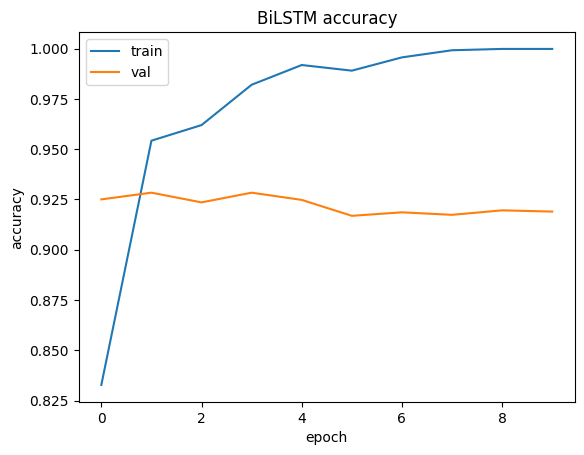

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('BiLSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

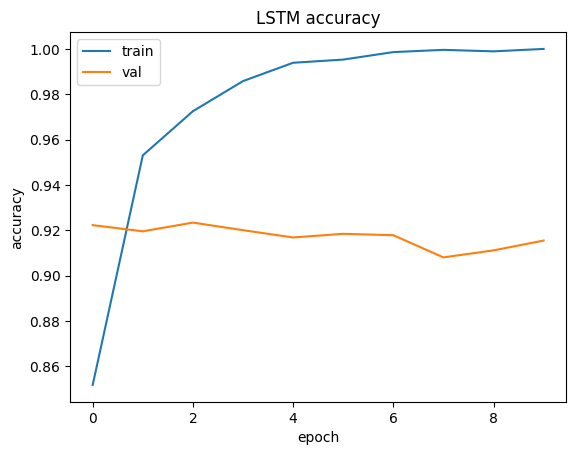

In [ ]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('LSTM accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

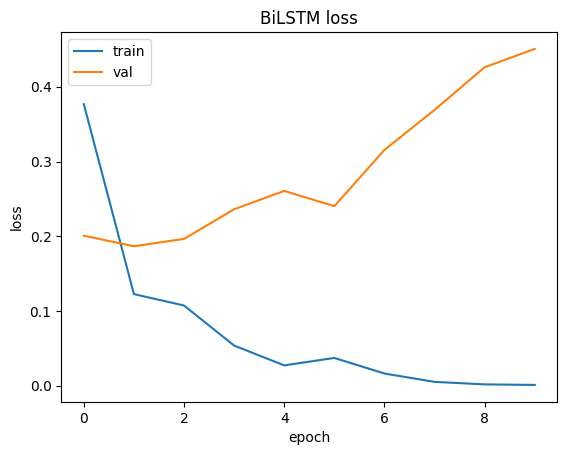

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BiLSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

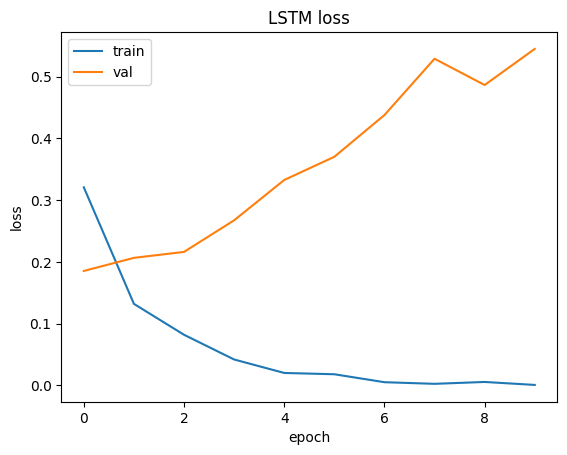

In [ ]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('LSTM loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

<font color='#7ed6df'>Evaluate Performance with Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred.round())

array([[3775,  378],
       [ 277, 3652]])

In [ ]:
confusion_matrix(y_test, y_pred1.round())

array([[3788,  365],
       [ 318, 3611]])

In [ ]:
model.evaluate(embed_input, y, batch_size =  32)

632/632 [==============================] - 11s 16ms/step - loss: 0.1806 - accuracy: 0.9675


[0.180584117770195, 0.9675295948982239]

In [ ]:
model1.evaluate(embed_input, y, batch_size =  32)

632/632 [==============================] - 5s 8ms/step - loss: 0.2165 - accuracy: 0.9662


[0.21645793318748474, 0.9661931395530701]

In [ ]:
x_title = []
def classification(x):
    headline = re.sub('[^a-zA-Z]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    headline = [ws.lemmatize(word) for word in headline if word not in stopwords.words("english")]
    headline = ' '.join(headline)
    x_title.append(headline)
    hot_title = [one_hot(i, vocab) for i in x_title]
    embed_input = pad_sequences(hot_title, maxlen = max_length, padding='pre')
    x_pred = model.predict(embed_input)
    if(x_pred[0][0]>0.5):
      return "Fake"
    elif(x_pred[0][0]<0.5):
      return "Not Fake"

1/1 [==============================] - 0s 28ms/step


'Fake'